Название: Проект изучения причин убыльности рекламной компании Procrastinate Pro+.

Краткое описание проекта: компании Procrastinate Pro+ не смотря на большгие вложения в рекламе терпит убытки. Для анализа есть данные по посещению, покупкам и затратах на рекламу.

Цели проекта: Выяснить причины убыльности бизнеса.

Задачи проекта: 1. откуда приходят пользователи и какими устройствами они пользуются,
2. сколько стоит привлечение пользователей из различных рекламных каналов;
3. сколько денег приносит каждый клиент,
4. когда расходы на привлечение клиента окупаются,
5. какие факторы мешают привлечению клиентов.

Даны три дата фрейма: 
1. посещения клиентов (id пользователя, страна, устройство, канал, время окончания и начала сессии)
2. заказы пользоватетелей (id пользователя, дата заказа, сумма заказа )
3. затраты на рекламу по каналам (дата затрат, канал затрат, количество затрат)

План:
1. проверить данные на корректность
2. создать функции для оптимизации дальнейшей работы
3. провести исследовательский анализ (создать профили пользователей, проанализировать приход платящих пользователей на сайт по странам, по девайсам, по каналам)
4. провести маркетинговый анализ (расчитать САС)
5. оценить окупаемость рекламы (создать графики LTV, CAC и ROI в разрезе стран, девайсов и каналов, выявит проблемы)
6. сделать выводы по всему проекту, сделать предположения почему реклама не окупается.

# Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('visits_info_short.csv')  
orders = pd.read_csv('orders_info_short.csv')  
costs = pd.read_csv('costs_info_short.csv')  

In [3]:
tables = [visits, orders, costs]
for x in tables:
    print(x.info())
    print()
    columns = list(x.columns)
    for y in columns:
        print(x[y].describe())
        print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

count    3.099010e+05
mean     4.997664e+11
std      2.887899e+11
min      5.993260e+05
25%      2.493691e+11
50%      4.989906e+11
75%      7.495211e+11
max      9.999996e+11
Name: User Id, dtype: float64

count            309901
unique                4
top       United States
freq             207327
Name: Region, dtype: object

count     309901
unique         4
top       iPhone
freq      112603
Name: Device, dtype: object

count      309901
unique         11
top       organi

Видим, что отсутсвующих данных нет, нереалистично больших данных тоже нет. Из недочётов, можно исправить названия столбцов, убрать верхний регистр и пробелы (заменить на '_')

In [4]:
for x in tables:
    columns = list(x.columns)
    for n in range(len(columns)):
        columns[n] = columns[n].lower()
        columns[n] = columns[n].replace(' ', '_')
    x.columns = columns
for x in tables:
    print(x.columns)
   
    

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')
Index(['user_id', 'event_dt', 'revenue'], dtype='object')
Index(['dt', 'channel', 'costs'], dtype='object')


преобразуем данные с датой в соответствующий тип данных

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])
print(orders)
print(orders.info())


            user_id            event_dt  revenue
0      188246423999 2019-05-01 23:09:52     4.99
1      174361394180 2019-05-01 12:24:04     4.99
2      529610067795 2019-05-01 11:34:04     4.99
3      319939546352 2019-05-01 15:34:40     4.99
4      366000285810 2019-05-01 13:59:51     4.99
...             ...                 ...      ...
40207  651604369137 2019-10-31 16:19:07     4.99
40208  275341387049 2019-10-31 01:17:17     4.99
40209  374656616484 2019-10-31 06:17:29     4.99
40210  168548862926 2019-10-31 22:46:19     4.99
40211  329994900775 2019-10-31 13:29:06     4.99

[40212 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)


Проверим уникальные значения

In [6]:
for x in tables:
    columns = list(x.select_dtypes(include='object').columns)
    for y in columns:
        print(x[y].unique())

['United States' 'UK' 'France' 'Germany']
['iPhone' 'Mac' 'Android' 'PC']
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


никаких повторяющихся значений не обнаружено

Проверим на дубликаты

In [7]:
for x in tables:
    print(x.duplicated().sum())


0
0
0


Дубликатов нет

In [8]:
for x in tables:
    print(x.columns)

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')
Index(['user_id', 'event_dt', 'revenue'], dtype='object')
Index(['dt', 'channel', 'costs'], dtype='object')


In [9]:
for x in tables:
    print(round((x.isna().mean()*100),2))
    print()

user_id          0.0
region           0.0
device           0.0
channel          0.0
session_start    0.0
session_end      0.0
dtype: float64

user_id     0.0
event_dt    0.0
revenue     0.0
dtype: float64

dt         0.0
channel    0.0
costs      0.0
dtype: float64



Вывод: 
1. значений Nan не обнаружено
2. экстремально (выбивающихся) больших или маленьких данных не обнаружено
3. дубликатов не обнаружено
4. одинаковых значений отличающихся регистром не обнаружено
5. преобразованы данные с датой


# Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

In [10]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    new_users['dt'] = pd.to_datetime(new_users['dt'])
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
#     добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
#     # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [13]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [14]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [17]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

# Шаг 3. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Определим минимальную и максимальную даты привлечения пользователей.

Создадим профили посетителей сайта

In [18]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head())

    user_id            first_ts     channel  device         region  payer  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   True   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States  False   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France  False   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany  False   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States  False   

          dt      month  acquisition_cost  
0 2019-05-07 2019-05-01          1.088172  
1 2019-07-09 2019-07-01          1.107237  
2 2019-10-01 2019-10-01          0.000000  
3 2019-08-22 2019-08-01          0.988235  
4 2019-10-02 2019-10-01          0.230769  


In [19]:
display(profiles.first_ts.min())
display(profiles.first_ts.max())

Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-27 23:59:04')

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [20]:
region_pay = profiles.groupby('region').agg({'user_id': 'count', 'payer': 'sum'})
region_pay['percent_pay'] = (region_pay.payer / region_pay.user_id) * 100
region_pay

,user_id,payer,percent_pay
region,,,
France,17450,663,3.799427
Germany,14981,616,4.111875
UK,17575,700,3.982930
United States,100002,6902,6.901862


Самое большое количество пользователей пришло из США, из этой же страны самый большой процент платящих пользователей. Остальные страны (Великобритания, Германия и Франция) примерно на одном уровне отстают от США

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построем таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [21]:
device_pay = profiles.groupby('device').agg({'user_id': 'count', 'payer': 'sum'})
device_pay['percent_pay'] = (device_pay.payer / device_pay.user_id) * 100
device_pay

,user_id,payer,percent_pay
device,,,
Android,35032,2050,5.851793
Mac,30042,1912,6.364423
PC,30455,1537,5.046790
iPhone,54479,3382,6.207897


Самое большое количество пользователей пользуются устройством 'iPhone', его пользователи почти в 2 раза превышают пользователей других систем. По количеству платящих лидируют системы 'iPhone','Mac', далее идут андроид пользователи и существенно отстают от остальных пользователи 'PC'

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [22]:
channel_pay = profiles.groupby('channel').agg({'user_id': 'count', 'payer': 'sum'})
channel_pay['percent_pay'] = (channel_pay.payer / channel_pay.user_id) * 100
channel_pay.sort_values(by='percent_pay', ascending=False)

,user_id,payer,percent_pay
channel,,,
FaceBoom,29144,3557,12.204914
AdNonSense,3880,440,11.340206
lambdaMediaAds,2149,225,10.469986
TipTop,19561,1878,9.600736
RocketSuperAds,4448,352,7.913669
WahooNetBanner,8553,453,5.296387
YRabbit,4312,165,3.826531
MediaTornado,4364,156,3.574702
LeapBob,8553,262,3.063253


Самое большое  количество пользователей приходит с канала 'organic' который лидирует с большим отрывом, но не смотря на обширную аудиторию (платящих пользоватей с канала меньше всего), следом по количеству пользователей идёт канал 'FaceBoom', у данного канала, самое большое процентное соотношение платящих пользователей, на третьем месте располагается канал 'TipTop' (у канала процент платящих находится на достаточно высоком уровне), остальные каналы имеют намного меньшее количество пользоватетелей. Среди не популярных каналов, с хорошим показателей процента платящих пользоватетелй можно выделить каналы 'lambdaMediaAds' с очень хорошим показателем 10,47% и канал 'RocketSuperAds' с показателем 7,91 %

Общий вывод по количеству платящих пользователей, самым чувсвительным показателем оказался канал с которого пришёл пользователь, в зависимости от платформы, показатели очень сильно разнятся

# Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируйте изменения метрик во времени.

In [23]:
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [24]:
top_chanel_costs = costs.pivot_table(index='channel',values='costs', aggfunc='sum').sort_values(by='costs', ascending=False)
top_chanel_costs

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Самые большие затраты у 'TipTop', который лидирует с большим отрывом, а так же на втором месте так же с большим отрывом от остальных лидирует 'FaceBoom'

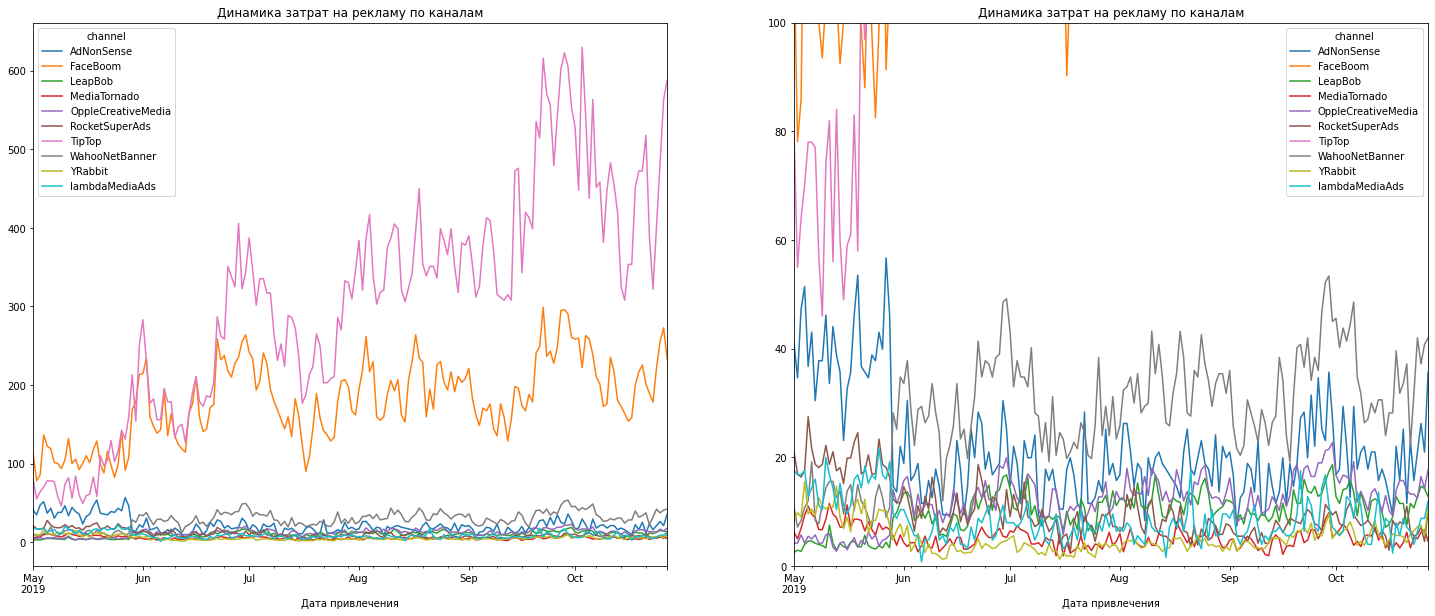

In [25]:
ax1 = plt.subplot(1,2,1)
costs\
.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')\
.plot(figsize=(25,10),ax=ax1)
plt.xlabel('Дата привлечения')
plt.title('Динамика затрат на рекламу по каналам')

ax2 = plt.subplot(1,2,2)
costs\
.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')\
.plot(figsize=(25,10),ylim=(0,100), ax=ax2) 
plt.xlabel('Дата привлечения')
plt.title('Динамика затрат на рекламу по каналам')
plt.show()

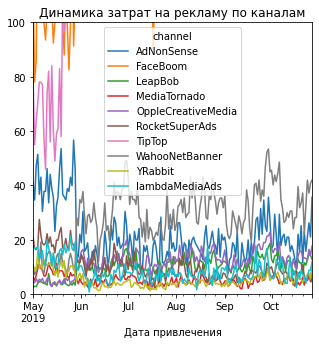

In [26]:
costs\
.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum').\
plot(figsize=(5,5),ylim=(0,100))
plt.xlabel('Дата привлечения')
plt.title('Динамика затрат на рекламу по каналам')
plt.show()

Сгладим графики

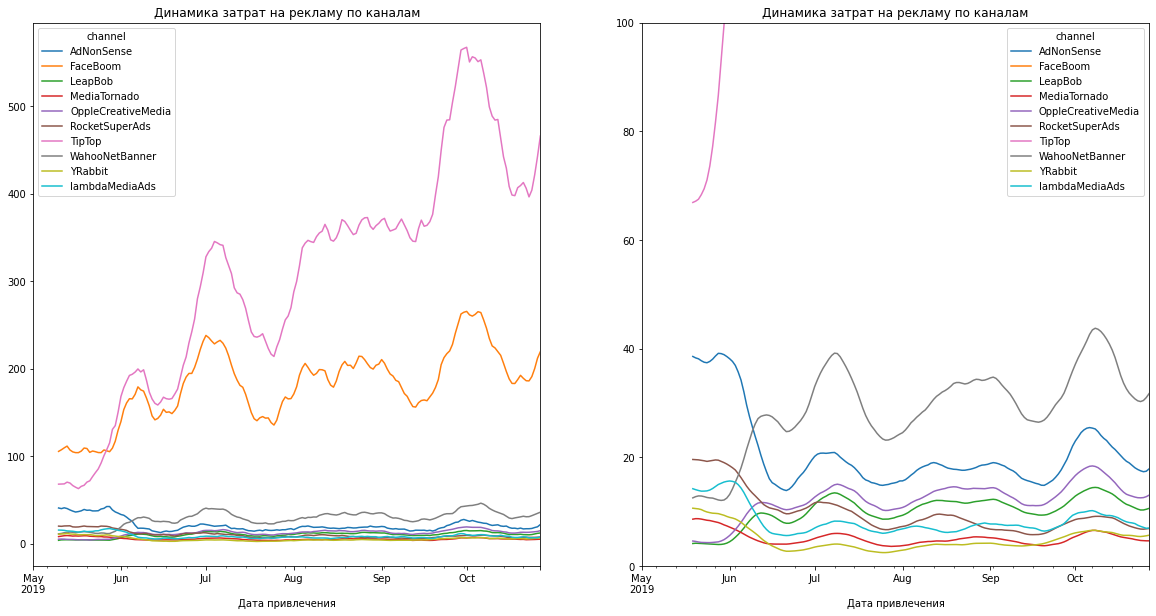

In [27]:
graf = costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')
ax1 = plt.subplot(1,2,1)
filter_data(graf, 10).plot(figsize=(20,10),ax=ax1)
plt.xlabel('Дата привлечения')
plt.title('Динамика затрат на рекламу по каналам')
ax2 = plt.subplot(1,2,2)
filter_data(graf, 10).plot(figsize=(20,10),ylim=(0,100),ax=ax2)
plt.xlabel('Дата привлечения')
plt.title('Динамика затрат на рекламу по каналам')
plt.show()

Мы видим, что топовые сети по рекламным затратам увеличивали свои затраты на рекламу скачкообразно, локальные пики приходились на начало июня на начало июля, на начало августа, в целом по сетям 'TipTop' и 'FaceBoom' положительный тренд по затратам на рекламу. остальные же сети в целом находятся в постоянно низких или снижающихся по затратам. Из компаний с низким бюджетом можно только выделить компанию 'WahooNetBanner' у которой есть положительная динамика затрат.

In [28]:
# Общая сумма трат на покупки
orders.revenue.sum()

215962.88

In [29]:
# общая сумма расходов на маркетинг
costs.costs.sum()

105497.30000000002

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.

In [30]:
cac = profiles.groupby('channel').agg({'acquisition_cost':'sum', 'user_id':'nunique'})
cac['cac'] = cac['acquisition_cost'] / cac['user_id'] 
cac.sort_values(by='cac', ascending=False)

,acquisition_cost,user_id,cac
channel,,,
TipTop,54751.30,19561,2.799003
FaceBoom,32445.60,29144,1.113286
AdNonSense,3911.25,3880,1.008054
lambdaMediaAds,1557.60,2149,0.724802
WahooNetBanner,5151.00,8553,0.602245
RocketSuperAds,1833.00,4448,0.412095
OppleCreativeMedia,2151.25,8605,0.250000
YRabbit,944.22,4312,0.218975
MediaTornado,954.48,4364,0.218717


In [31]:
print(cac.cac.mean())

0.6870317251013996


In [32]:
cac.query('channel != "organic"').acquisition_cost.sum() / cac.query('channel != "organic"').user_id.sum()

1.127481323942759

больше всего на привлечении одного пользователя уходит затрат на площадке 'Tip-top', площадка лидирует с большим отрывом, на втором месте площадки 'FaceBoom' и 'AdNonSense'. В целом видна зависимость, чем больше тратися на рекламу тем дороже выходят пользователи, эффекта масштаба (при котором количество затрачеваемой рекламы, резко давало бы низкие расходы на одного пользователя) не видно.



# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

In [33]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

### Проанализируйте общую окупаемость рекламы

In [34]:
# исправление profiles
profiles = profiles.query('channel != "organic"')

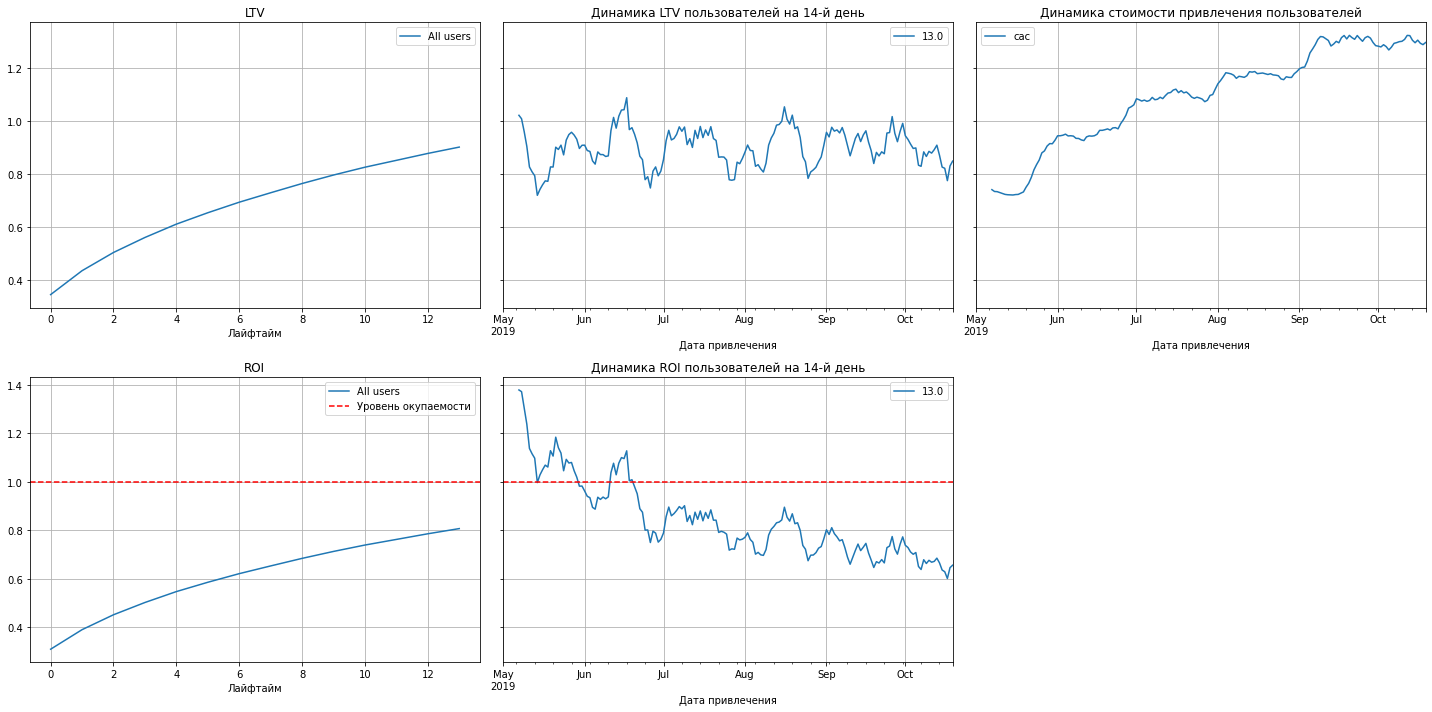

In [35]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Видим что эффективность рекламной компании падает, в среднем за обозреваемый период реклама не окупалась, вложения в рекламу увеличивались, а показатель ROI имеет отрицательную динамику (на начальном этапе ROI был выше 1, что скорее всего обусловлено низкими вложениями в рекламу)

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

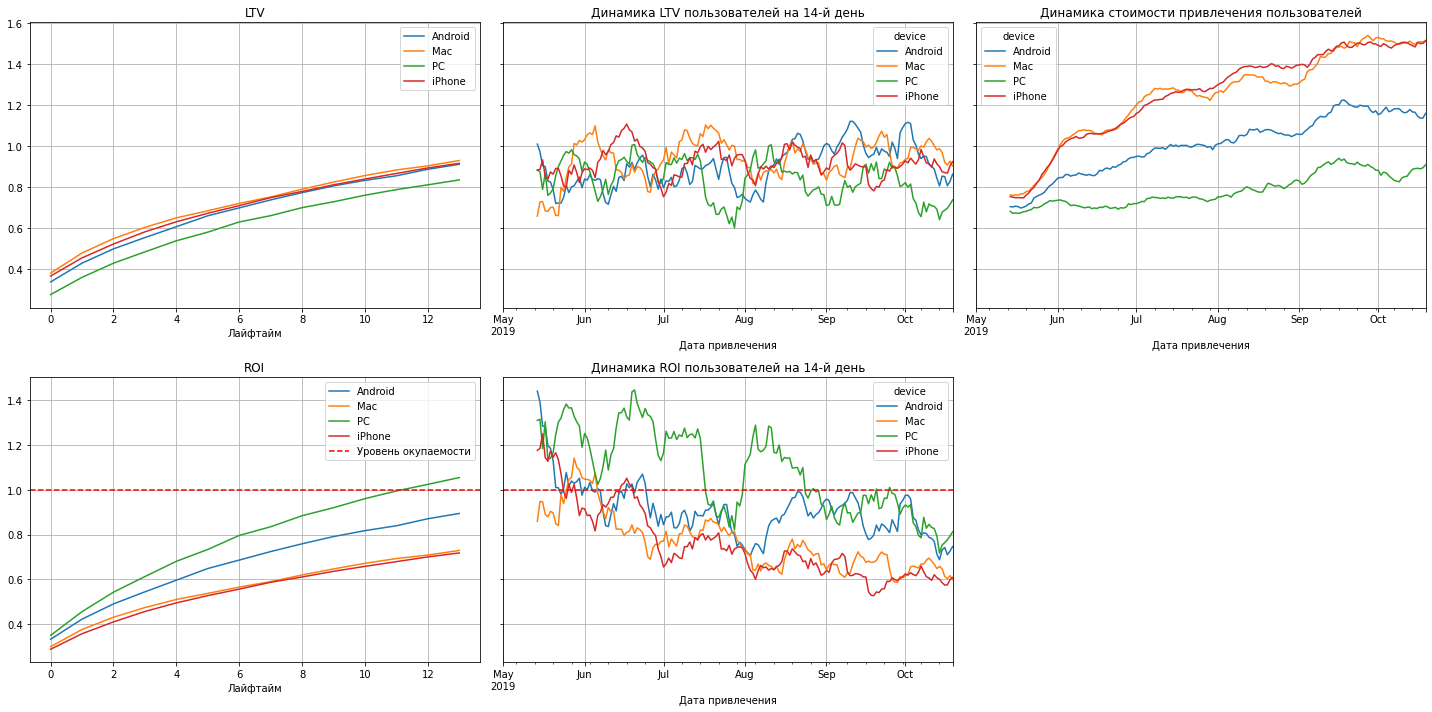

In [36]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По устройствам можем отметить, так же как и в среднем общую динамику падения показателя ROI для всех типов устройств. Хоть и и все устройтва находятся по показателю ROI в нисходящем тренде, можно отметить что реклама на девайсы ПК окупает себя (хотя в последнее время уже в плотную приблизилась к линии безубыточности). Можно отметить общий показатель ROI к убыточности тянут за собой девайсы iphone и mac, так как у этих девайсов больше всего выросли затраты на рекламу. Андроид устройствы в самом начале были самые перспективные по показателю ROI, но сильно скатились почти до показателя iphone и mac


### Проанализируйте окупаемость рекламы с разбивкой по странам

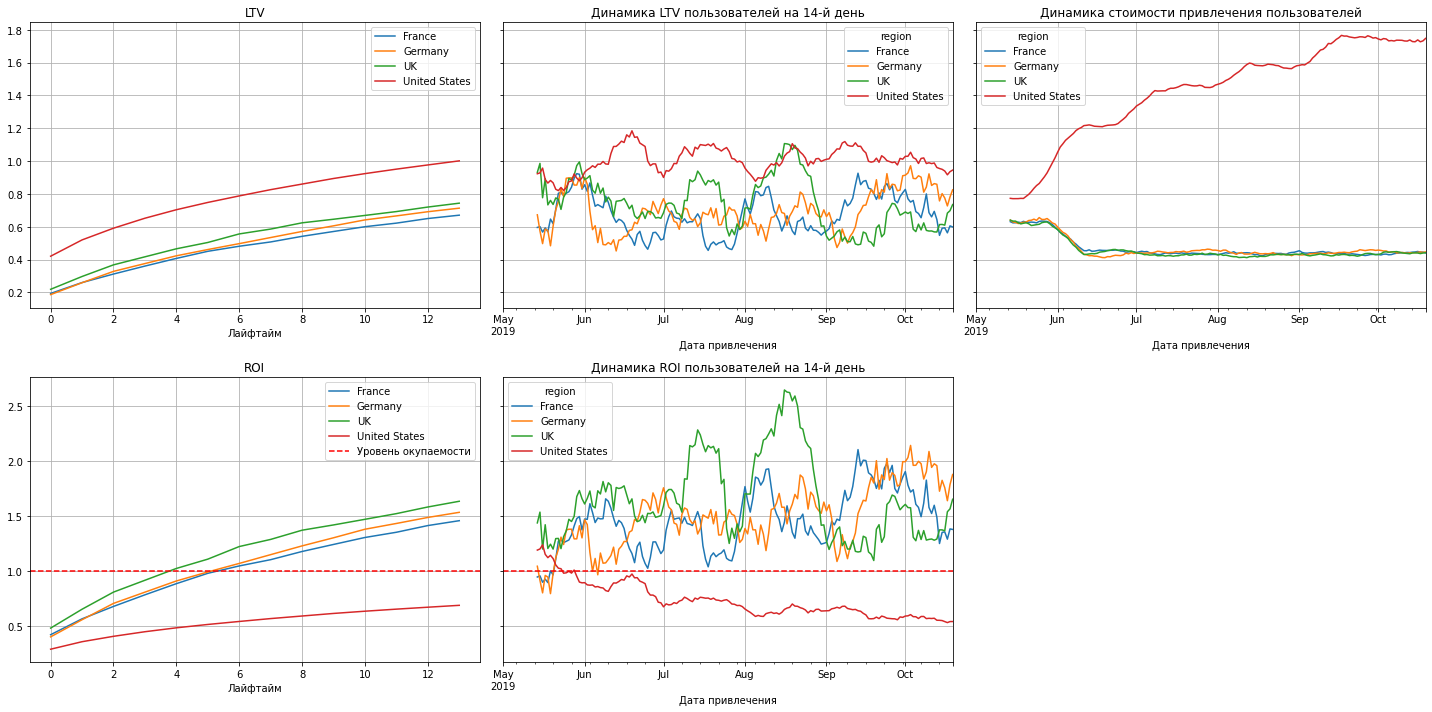

In [37]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По всем странам, кроме США, мы видими хорошие показатели ROI, которые выходят за линию безубыточности, на все страны кроме США тратится на всём промежутке иследуемого периода почти одинаковая денежная сумма, показатель LTV на всём промежутке находится в одном и том же диапазоне, динамика ROI на 14-ый день тоже коллеблится, но тоже находится в одном и том же диапазоне.
Явно в отрицательную сторону выделяется показатели по стране США, заметно очень сильное повышение уровня затрат, на одного пользователя, что и отражается на показателе ROI который, на последний момент анализируемого периода, находится в в сильной регрессии и далеко внизу за точкой безубыточности

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

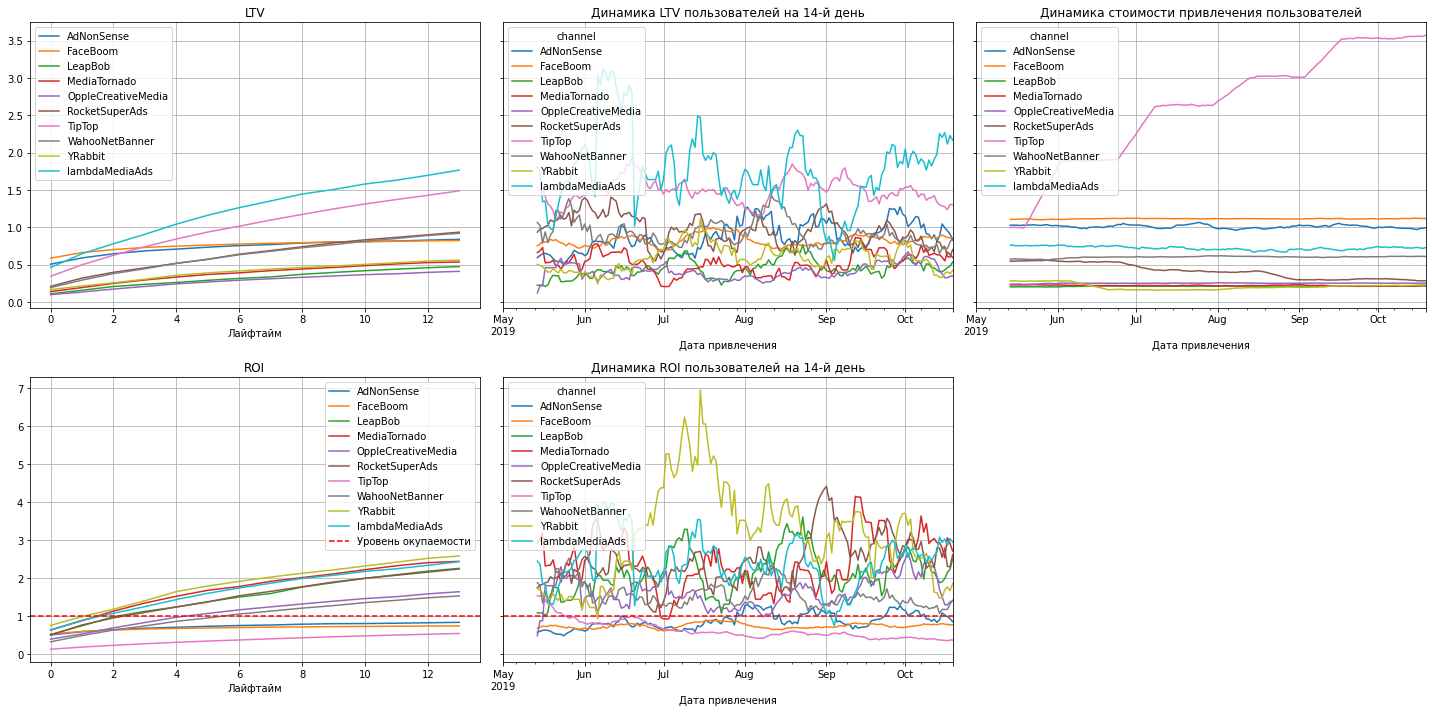

In [38]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Анализируя каналы можно выделить проблему в том, что большие затраты на сеть TIP-TOP не окупают себя

Судя по различным разбивкам, основной проблемой стало, сильные рекламные затраты на одного человека по США, можно сделать вывод, что данный регион и тянет, всю рекламную компанию в минус

Необходимо подробней изучить, в чём может крыться проблема, данного региона

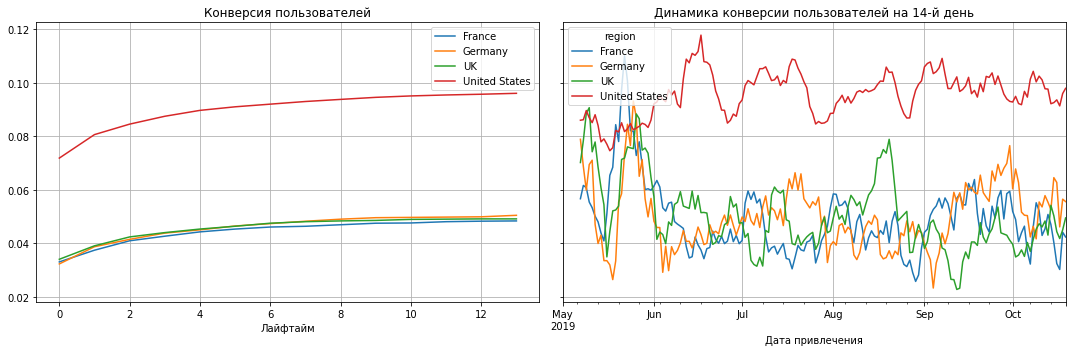

In [39]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия у пользователей США хорошая выше чем в остальных странах, рассмотрим, удержание по странам

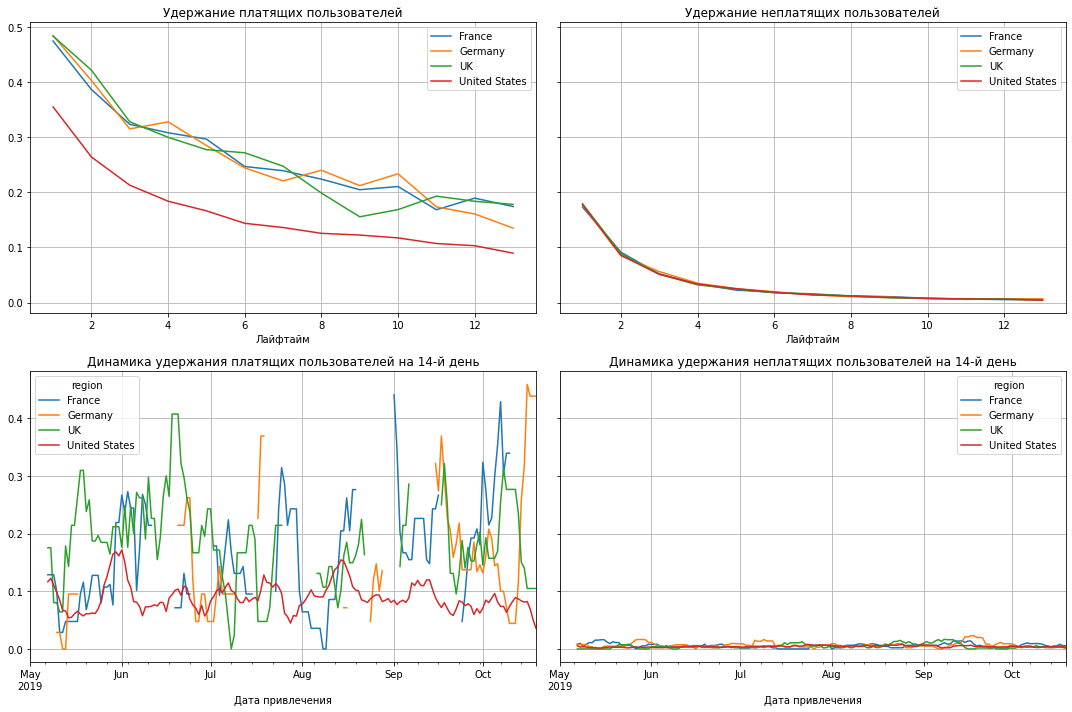

In [40]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Выяснилось, что удержание именно у платящих пользователей США самое низкое низкое.

Конверсия и удердание по устройствам 

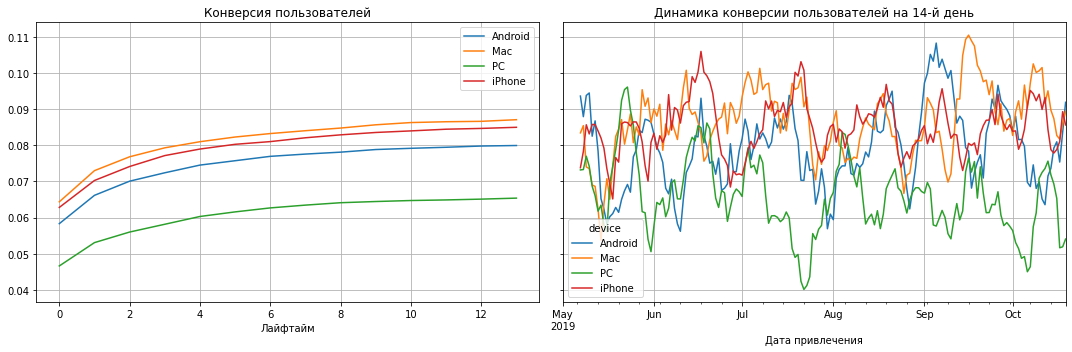

In [41]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

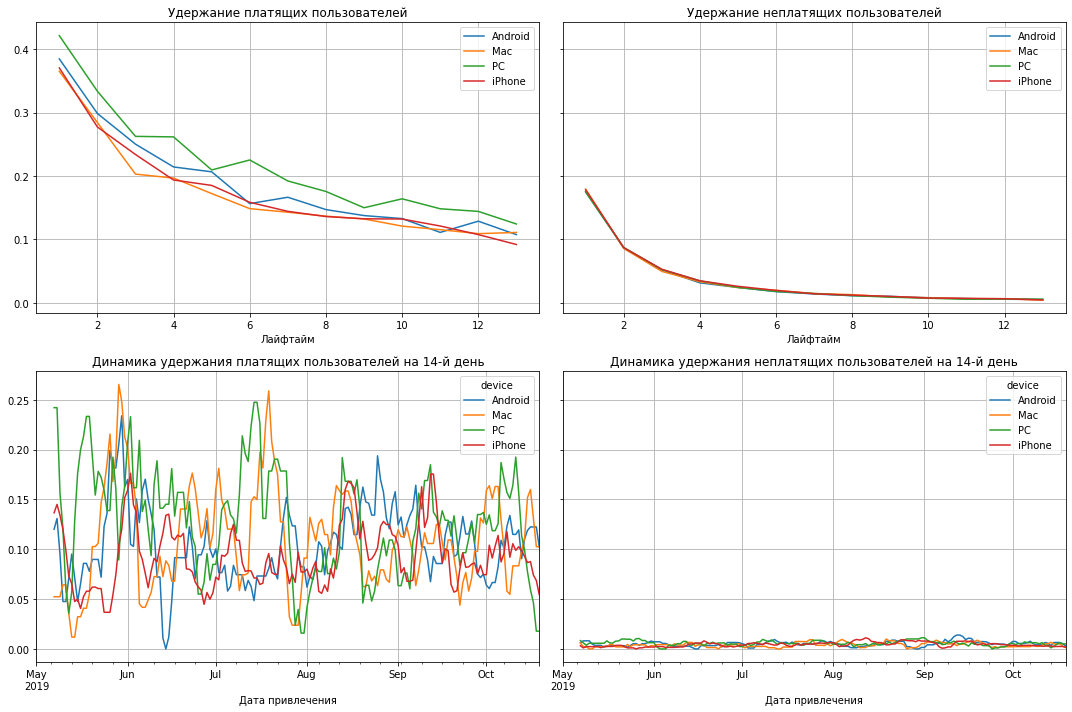

In [42]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Конверсия и удердание по каналам

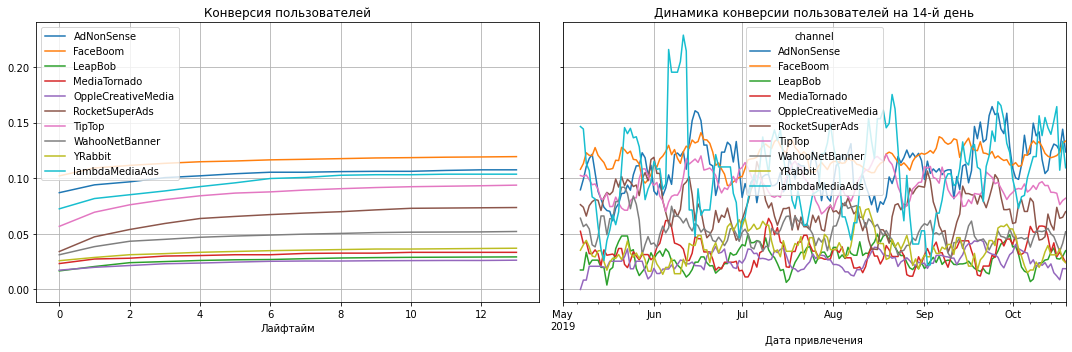

In [43]:
# смотрим конверсию с разбивкой по каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

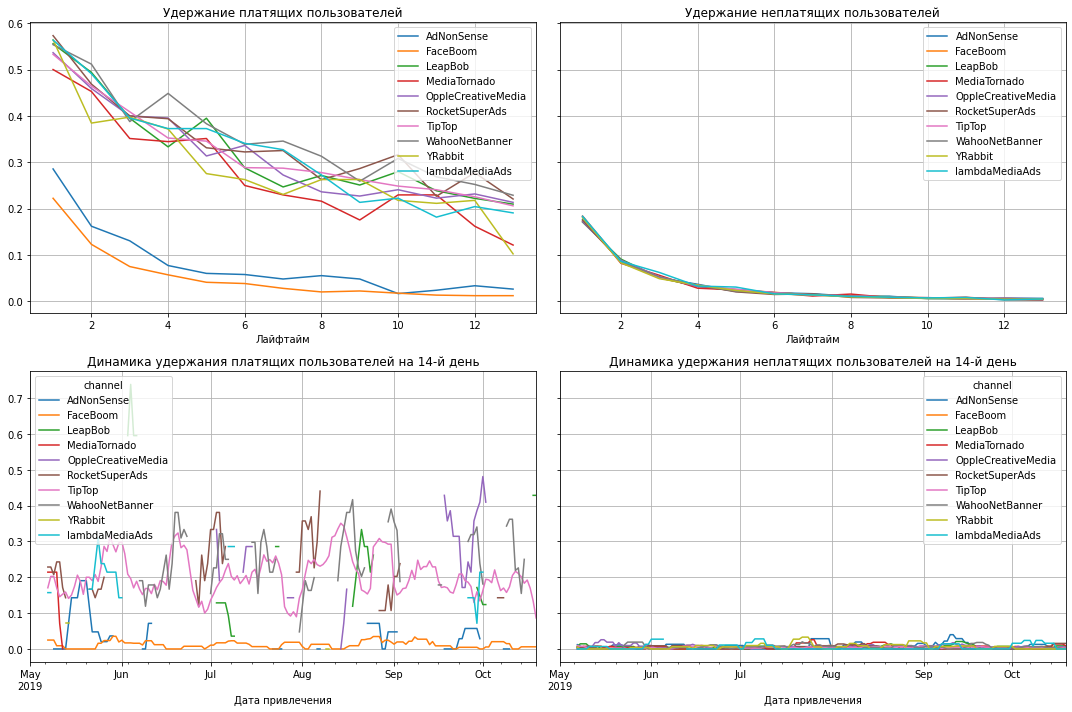

In [44]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

1. Анализируя конвесию и удержание по устройствам, выбивающихся данных нет, можно отметить, что не смотря на низкую конверсию ПК пользователей, их показатель удержания высокий, но в целом в процентном соотношении удержание по всем пользователем от первого до последнего лайфтайма, одинаковое, как и показатель коверсии.
2. По каналам заметно не смотря на самую высоку конверсию канала 'FaceBoom' у него самое низкое удержание пользователей и низкий ROI (реклама себя не окупает)


# Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

Топовые сети по рекламным затратам увеличивали свои затраты на рекламу скачкообразно, локальные пики приходились на начало июня на начало июля, на начало августа, в целом по сетям 'TipTop' и 'FaceBoom' иммеет положительный тренд по затратам на рекламу. остальные же сети в целом находятся в постоянно низких или снижающихся затратах. Из компаний с низким бюджетом можно только выделить компанию 'WahooNetBanner' у которой есть поднимающаяся динамика затрат.

больше всего на привлечении одного пользователя уходит затрат на площадке 'Tip-top', площадка лидирует с большим отрывом, на втором месте площадки 'FaceBoom' и 'AdNonSense'. В целом видна зависимость, чем больше тратися на рекламу тем дороже выходят пользователи, эффекта масштаба (при котором количество затрачеваемой рекламы, резко давало бы низкие расходы на одного пользователя) не видно.

Видим что эффективность рекламы у компании падает, в среднем за обозреваемый период реклама не окупалась, вложения в рекламу увеличивались, а показатель ROI имеет отрицательную динамику (на начальном этапе ROI был выше 1, что скорее всего обусловлено низкими вложениями в рекламу)

По устройствам можем отметить, так же как и в среднем общую динамику падения показателя ROI для всех типов устройств. Хоть и и все устройтва находятся по показателю ROI в нисходящем тренде, можно отметить что реклама на девайсы ПК окупает себя (хотя в последнее время уже в плотную приблизилась к линии безубыточности). Можно отметить общий показатель ROI к убыточности тянут за собой девайсы iphone и mac, так как у этих девайсов больше всего выросли затраты на рекламу. Андроид устройствы в самом начале были самые перспективные по показателю ROI, но сильно скатились почти до показателя iphone и mac

По всем странам, кроме США, мы видими хорошие показатели ROI, которые выходят за линию безубыточности, на все страны кроме США тратится на всём промежутке иследуемого периода почти одинаковая денежная сумма, показатель LTV на всём промежутке находится в одном и том же диапазоне, динамика ROI на 14-ый день тоже коллеблится, но тоже находится в одном и том же диапазоне.
Явно в отрицательную сторону выделяется показатели по стране США, заметно очень сильное повышение уровня затрат, на одного пользователя, что и отражается на показателе ROI который, на последний момент анализируемого периода, находится в в сильной регрессии и далеко внизу за точкой безубыточности

Анализируя каналы можно выделить проблему в том, что большие затраты на сеть TIP-TOP не окупают себя

Судя по различным разбивкам, основной проблемой стало, сильные рекламные затраты на одного человека по США, можно сделать вывод, что данный регион и тянет, всю рекламную компанию в минус

По графикам конверсии и удержания мы увидели, проблему плохого удержания платящих пользователей по США, можно сделать вывод, что нужно разобраться в технической составляющей продукта, вполне возможно, сервис оплаты плохо работает в США. Так же можно пересмотреть рекламную компанию продукта, и не тратить большие финансовые средства на рекламную компанию в США, поскольку только в этой стране, реклама себя не окупает.

Были выявлены плохие причины окупаемости рекламы:
1. низкий показатель ROI в США, при чём этот показатель продолжает падать (причиной тому вполне вероятно может низкое удержание платящих пользоватетей)
2. При одних из самых больших затрат на пользователя канала FaceBoom у данного канла низкое удержание пользователей 
3. У канала 'Tip-top' при самых высоких затратах общих и на пользователя показатель ROI так же ниже окупаемости, у данного канала удержание и конверсия находятся в норме, низкий показатель ROI может быть обусловлен общей высокой стоимостью рекламы в расчёте на привлечение на одного пользователя.

Рекомендации:
1. изучить почему сбегают пользователи США, может есть проблемы с может есть проблемы с сервисом в данном регионе
2. изучить почему сбегают пользователи FaceBoom, оптимизировать рекламу, т.к у этого канала высокие затраты на одного пользователя
3. оптимизировать рекламу канала Tip-top выходят слишком высокие рекламные затраты на одного пользователя (стоимость рекламы не эквивалента привлечённым пользователям)
4. Есть потенциал повышения конверсии у пользователей в Европе (стоит проанализировать, может есть проблемы с оплатой, на каком этапе, отваливаются платящие пользователи)